# Implementation Step (need to seperate to both models )

- Load dataset
- Load the model 
- Normalizing data
- Train and Capture the period of training time
- Save the model weight, log of training time and hyperparameter to text file
- 

In [1]:
import torch

# Set seed
torch.manual_seed(2023)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Prepare the data set in 3 channels

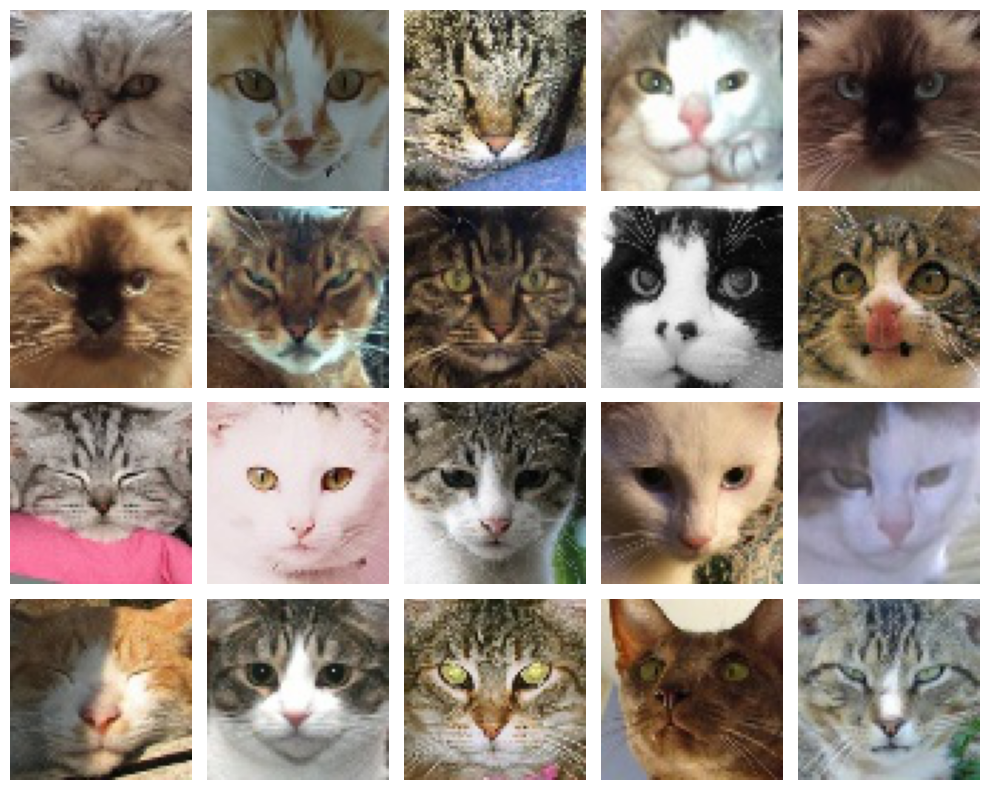

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Set the path to the dataset
dataset_path = 'cats'

# Get the list of image filenames
image_filenames = os.listdir(dataset_path)

# Set the number of images to plot
num_images = 20

# Create a new figure with multiple subplots
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))

# Iterate over the first num_images filenames and plot the corresponding images
for i, filename in enumerate(image_filenames[:num_images]):
    # Load the image
    img_path = os.path.join(dataset_path, filename)
    img = Image.open(img_path)

    # Convert the image to a numpy array
    img_arr = np.asarray(img)

    # Plot the image on the corresponding subplot
    row = i // 5
    col = i % 5
    axes[row, col].imshow(img_arr, cmap='gray')
    axes[row, col].axis('off')

# Adjust the spacing of the figure
fig.tight_layout()

# Show the figure
plt.show()


### load image to tenser

In [3]:
#set hyperarameter
IMG_SIZE = 64
BATCH_SIZE = 16

In [4]:
import torch
from torchvision.transforms import transforms
from PIL import Image
import os

# Set the path to the dataset
dataset_path = 'cats'

# Get the list of image filenames
image_filenames = os.listdir(dataset_path)

# Set the number of images to transform
num_images = 10000

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # convert PIL image to tensor and scales data into [0,1] 
    # transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # Scale between [-1, 1] by (input[channel] - mean[channel]) / std[channel]
])

# Create a list to store the transformed images
transformed_images = []

# Iterate over the first num_images filenames and transform the corresponding images
for i, filename in enumerate(image_filenames[:num_images]):
    # Load the image
    img_path = os.path.join(dataset_path, filename)
    image = Image.open(img_path)

    # Apply the transformations
    transformed_image = transform(image)

    # Append the transformed image to the list
    transformed_images.append(transformed_image)

# Convert the list of transformed images to a PyTorch tensor
transformed_images = torch.stack(transformed_images)

print(f'Loaded data: {transformed_images.shape}')

Loaded data: torch.Size([10000, 3, 64, 64])


In [5]:
from torch.utils.data import DataLoader

dataloader = DataLoader(transformed_images, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [6]:
import matplotlib.pyplot as plt

def show_tensor_image(image, index=0):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[index, :, :, :] 
    plt.imshow(reverse_transforms(image))

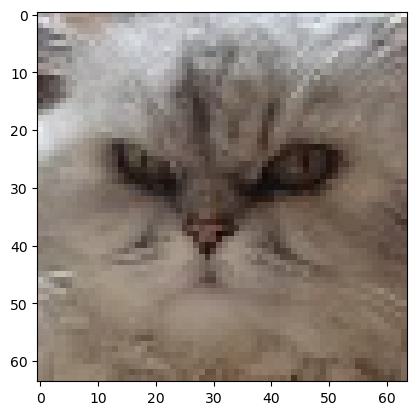

In [7]:
show_tensor_image(transformed_images)

## Create the Model

In [8]:
#set hyperarameter


EPOCHS = 100
IMG_SIZE = 64
BATCH_SIZE = 16

LR = 0.0002
B1 = 0.5
B2 = 0.999
CHANNELS = 3
LATENT_DIM = 100


In [9]:
import argparse
import os
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch as torch

cuda = True if torch.cuda.is_available() else False

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = IMG_SIZE // 4
        self.l1 = nn.Sequential(
            nn.Linear(LATENT_DIM, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, CHANNELS, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(
                0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(CHANNELS, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = IMG_SIZE // 2 ** 4
        self.adv_layer = nn.Sequential(
            nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(
    generator.parameters(), lr=LR, betas=(B1, B2))
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), lr=LR, betas=(B1, B2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

## Train the model 

In [10]:
import argparse
import os
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as F
import torch as torch

for epoch in range(EPOCHS):
    for step, batch in enumerate(dataloader):

        # Adversarial ground truths
        valid = torch.ones((batch.shape[0], 1)).to(device)
        fake = torch.zeros((batch.shape[0], 1)).to(device)

         # Configure input
        real_imgs = batch.type(Tensor)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Tensor(np.random.normal(
            0, 1, (batch.shape[0], LATENT_DIM)))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        batches_done = (epoch * len(dataloader)) + step

        if batches_done % len(dataloader) == 0:
            print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, EPOCHS, step, len(dataloader), d_loss.item(), g_loss.item())
            )
            save_image(gen_imgs.data[:10], f"images/{epoch}.png", nrow=5, normalize=True)

print(f"Done {EPOCHS}")
        

[Epoch 0/100] [Batch 0/625] [D loss: 0.693279] [G loss: 0.682377]
[Epoch 1/100] [Batch 0/625] [D loss: 0.708454] [G loss: 0.667469]
[Epoch 2/100] [Batch 0/625] [D loss: 0.696013] [G loss: 0.680215]
[Epoch 3/100] [Batch 0/625] [D loss: 0.691375] [G loss: 0.694316]
[Epoch 4/100] [Batch 0/625] [D loss: 0.696498] [G loss: 0.684869]


### Save the weight

In [ ]:
generator.state_dict()

In [ ]:
import torch 

torch.save(generator.state_dict(), "weight/DCGAN.pth")

## code below use to standalize

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

dataset = datasets.ImageFolder('test', transform=transforms.ToTensor())

mean = 0.
std = 0.
for images, _ in dataset:
    # Move the tensor to the CPU for faster processing
    images = images.cpu()
    # Calculate the mean and standard deviation of each color channel
    mean += images.mean(axis=(1,2))
    std += images.std(axis=(1,2))

# Divide by the number of images to get the mean and standard deviation of the dataset
mean /= len(dataset)
std /= len(dataset)

print('Mean:', mean)
print('Standard Deviation:', std)


Mean: tensor([0.4819, 0.4324, 0.3845])
Standard Deviation: tensor([0.2002, 0.1991, 0.1981])


## Evaluate the model with FID script

## Plot Graph from log file

### Masure Step

- use the model to generate around 10000 sameples and masure FID score
- Visualize the score to compare 

In [ ]:
import time

start_time = time.time() 
test = [i for i in range(0,100000)]
end_time = time.time()

def generateLog() -> None:
    model = ""
    epoch = "Epoch: 0"
    time = "\nSpending Time: " + "{:.2f}".format(end_time - start_time) # spending time 
    hyperPara = "\nLatent dimension: 100 \nImage size: 64x64 \nBatch size: 16 \nOptimizer: Adam \nLearning rate: 0.001"
    
    print(model+epoch+time+hyperPara)

generateLog()

Epoch: 0
Spending Time: 0.00
Latent dimension: 100 
Image size: 64x64 
Batch size: 16 
Optimizer: Adam 
Learning rate: 0.001


# log file example

In [ ]:
logData = '''Epoch: 0, Spending Time: 0.01, Latent dimension: 100, Image size: 64x64,Batch size: 16, Optimizer: Adam, Learning rate: 0.001'''
logFile = "logs/test.log"

print(logData)

# create log with script
%run ./modules/gen_log.py --log_file "$logFile" --message "$logData"

Epoch: 0, Spending Time: 0.01, Latent dimension: 100, Image size: 64x64,Batch size: 16, Optimizer: Adam, Learning rate: 0.001
